In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from models.utils import load_data, newey_west_tstat
from models.ols_model import OLSModel
from models.random_walk_model import RandomWalkModel
from models.lasso_model import LassoModel
from models.ridge_model import RidgeModel
from models.rf_model import RFModel
from models.gbf_model import GBFModel
from models.ar_model import ARModel
from models.hvz_model import HVZModel
from models.ri_model import RIModel
from models.xgb_model import XGBModel
from models.lightgbm_model import LightGBMModel
from models.catboost_model import CatBoostModel
from models.ann_model import ANNBaggingModel

sns.set(style="whitegrid")

In [33]:
# 1) OLS
df_ols = pd.read_csv(
    "full_results/ols_forecasts.csv",
    usecols=["gvkey", "year", "mkt_cap", "E", "E_future", "E_pred_ols"]
)
df_ols.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)

# 2) ANN
df_ann = pd.read_csv(
    "full_results/ann_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_ann_bagging"]
)
df_ann.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)

# Merge
df = df_ols.merge(df_ann, on=["gvkey", "year"], how="left")

# 3) AR
df_ar = pd.read_csv(
    "full_results/ar_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_ar"]
)
df_ar.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_ar, on=["gvkey", "year"], how="left")

# 4) CatBoost
df_cat = pd.read_csv(
    "full_results/catboost_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_catboost"]
)
df_cat.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_cat, on=["gvkey", "year"], how="left")

# 5) GBF
df_gbf = pd.read_csv(
    "full_results/gbf_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_gbf"]
)
df_gbf.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_gbf, on=["gvkey", "year"], how="left")

# 6) HVZ
df_hvz = pd.read_csv(
    "full_results/hvz_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_hvz"]
)
df_hvz.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_hvz, on=["gvkey", "year"], how="left")

# 7) Lasso
df_lasso = pd.read_csv(
    "full_results/lasso_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_lasso"]
)
df_lasso.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_lasso, on=["gvkey", "year"], how="left")

# 8) LightGBM
df_lgb = pd.read_csv(
    "full_results/lightgbm_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_lightgbm"]
)
df_lgb.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_lgb, on=["gvkey", "year"], how="left")

# 9) RF

df_rf = pd.read_csv(
    "full_results/rf_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_rf"]
)
df_rf.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_rf, on=["gvkey", "year"], how="left")

# 10) RI 
df_ri = pd.read_csv(
    "full_results/ri_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_ri"]
)
df_ri.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_ri, on=["gvkey", "year"], how="left")

# 11) Ridge
df_ridge = pd.read_csv(
    "full_results/ridge_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_ridge"]
)
df_ridge.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_ridge, on=["gvkey", "year"], how="left")

# 12) RW
df_rw = pd.read_csv(
    "full_results/rw_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_rw", "abs_error_rw_scaled"]
)
df_rw.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_rw, on=["gvkey", "year"], how="left")

# 13) XGB
df_xgb = pd.read_csv(
    "full_results/xgb_forecasts.csv",
    usecols=["gvkey", "year", "E_pred_xgb"]
)
df_xgb.drop_duplicates(subset=["gvkey", "year"], keep="first", inplace=True)
df = df.merge(df_xgb, on=["gvkey", "year"], how="left")

In [34]:
# 1. COMP_EXT: Mean of Extant Models
df["COMP_EXT"] = df[["E_pred_hvz", "E_pred_ri", "E_pred_ar"]].mean(axis=1)

# 2. COMP_LR: Mean of Linear Models
df["COMP_LR"] = df[["E_pred_ols", "E_pred_ridge", "E_pred_lasso"]].mean(axis=1)

# 3. COMP_NL: Mean of Nonlinear Models
df["COMP_NL"] = df[["E_pred_ann_bagging", "E_pred_catboost", "E_pred_gbf", "E_pred_lightgbm", "E_pred_xgb", "E_pred_rf"]].mean(axis=1) 

# 4. COMP_ML: Mean of Machine Learning Models
df["COMP_ML"] = df[["E_pred_ann_bagging", "E_pred_catboost", "E_pred_gbf", "E_pred_lightgbm", "E_pred_rf",
                    "E_pred_xgb", "E_pred_ols", "E_pred_ridge", "E_pred_lasso"]].mean(axis=1) 

df["abs_error_COMP_EXT_scaled"] = (df["COMP_EXT"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_LR_scaled"]  = (df["COMP_LR"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_NL_scaled"]  = (df["COMP_NL"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_ML_scaled"]  = (df["COMP_ML"] - df["E_future"]).abs() / df["mkt_cap"]

In [35]:
# 5. COMP_MED_EXT: Median of Extant Models
df["COMP_MED_EXT"] = df[["E_pred_hvz", "E_pred_ri", "E_pred_ar"]].median(axis=1)

# 6. COMP_MED_LR: Median of Linear Models
df["COMP_MED_LR"] = df[["E_pred_ols", "E_pred_ridge", "E_pred_lasso"]].median(axis=1)

# 7. COMP_MED_NL: Median of Nonlinear Models
df["COMP_MED_NL"] = df[["E_pred_ann_bagging", "E_pred_catboost", "E_pred_gbf", "E_pred_lightgbm", "E_pred_xgb", "E_pred_rf"]].median(axis=1) 

# 8. COMP_MED_ML: Median of Machine Learning Models
df["COMP_MED_ML"] = df[["E_pred_ann_bagging", "E_pred_catboost", "E_pred_gbf", "E_pred_lightgbm", "E_pred_rf",
                        "E_pred_xgb", "E_pred_ols", "E_pred_ridge", "E_pred_lasso"]].median(axis=1) 

df["abs_error_COMP_MED_EXT_scaled"] = (df["COMP_MED_EXT"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_MED_LR_scaled"]  = (df["COMP_MED_LR"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_MED_NL_scaled"]  = (df["COMP_MED_NL"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_COMP_MED_ML_scaled"]  = (df["COMP_MED_ML"] - df["E_future"]).abs() / df["mkt_cap"]

In [36]:
# Mean absolute forecast error of composite models
print("Mean absolute forecast error of composite models:")
print("COMP_EXT:", df["abs_error_COMP_EXT_scaled"].mean())
print("COMP_LR:", df["abs_error_COMP_LR_scaled"].mean())
print("COMP_NL:", df["abs_error_COMP_NL_scaled"].mean())
print("COMP_ML:", df["abs_error_COMP_ML_scaled"].mean())

Mean absolute forecast error of composite models:
COMP_EXT: 0.10536592466703364
COMP_LR: 0.09773049512128923
COMP_NL: 0.08149864329459117
COMP_ML: 0.08266756582148732


In [37]:
# Median absolute forecast error of composite models
print("\nMedian absolute forecast error of composite models:")
print("COMP_EXT:", df["abs_error_COMP_EXT_scaled"].median())
print("COMP_LR:", df["abs_error_COMP_LR_scaled"].median())
print("COMP_NL:", df["abs_error_COMP_NL_scaled"].median())
print("COMP_ML:", df["abs_error_COMP_ML_scaled"].median())


Median absolute forecast error of composite models:
COMP_EXT: 0.033971184159036445
COMP_LR: 0.03641157038592644
COMP_NL: 0.02794233909165449
COMP_ML: 0.02928916934789879


In [38]:
# Mean absolute forecast error of composite median models
print("\nMean absolute forecast error of composite median models:")
print("COMP_MED_EXT:", df["abs_error_COMP_MED_EXT_scaled"].mean())
print("COMP_MED_LR:", df["abs_error_COMP_MED_LR_scaled"].mean())
print("COMP_MED_NL:", df["abs_error_COMP_MED_NL_scaled"].mean())
print("COMP_MED_ML:", df["abs_error_COMP_MED_ML_scaled"].mean())


Mean absolute forecast error of composite median models:
COMP_MED_EXT: 0.09813501221064985
COMP_MED_LR: 0.09789871823974441
COMP_MED_NL: 0.07800160792287272
COMP_MED_ML: 0.0795160374403235


In [39]:
# Median absolute error of composite median models
print("\nMedian absolute forecast error of composite median models:")
print("COMP_MED_EXT:", df["abs_error_COMP_MED_EXT_scaled"].median())
print("COMP_MED_LR:", df["abs_error_COMP_MED_LR_scaled"].median())
print("COMP_MED_NL:", df["abs_error_COMP_MED_NL_scaled"].median())
print("COMP_MED_ML:", df["abs_error_COMP_MED_ML_scaled"].median())


Median absolute forecast error of composite median models:
COMP_MED_EXT: 0.03214462836672553
COMP_MED_LR: 0.036502535434835684
COMP_MED_NL: 0.027261786721820024
COMP_MED_ML: 0.028417101796332445


In [40]:
# Baseline Comparison
df["abs_error_rw_baseline"] = (df["E_pred_rw"] - df["E_future"]).abs() / df["mkt_cap"]
benchmark_mean = df["abs_error_rw_baseline"].mean()
benchmark_median = df["abs_error_rw_baseline"].median()
print("\nMean absolute forecast error of Random Walk model:", benchmark_mean)
print("Median absolute forecast error of Random Walk model:", benchmark_median)


Mean absolute forecast error of Random Walk model: 0.0892637024311975
Median absolute forecast error of Random Walk model: 0.02897265336289727


In [41]:
df["abs_error_ols_scaled"] = (df["E_pred_ols"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_ridge_scaled"] = (df["E_pred_ridge"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_lasso_scaled"] = (df["E_pred_lasso"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_ann_bagging_scaled"] = (df["E_pred_ann_bagging"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_catboost_scaled"] = (df["E_pred_catboost"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_gbf_scaled"] = (df["E_pred_gbf"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_lightgbm_scaled"] = (df["E_pred_lightgbm"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_rf_scaled"] = (df["E_pred_rf"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_xgb_scaled"] = (df["E_pred_xgb"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_hvz_scaled"] = (df["E_pred_hvz"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_ri_scaled"] = (df["E_pred_ri"] - df["E_future"]).abs() / df["mkt_cap"]
df["abs_error_ar_scaled"] = (df["E_pred_ar"] - df["E_future"]).abs() / df["mkt_cap"]

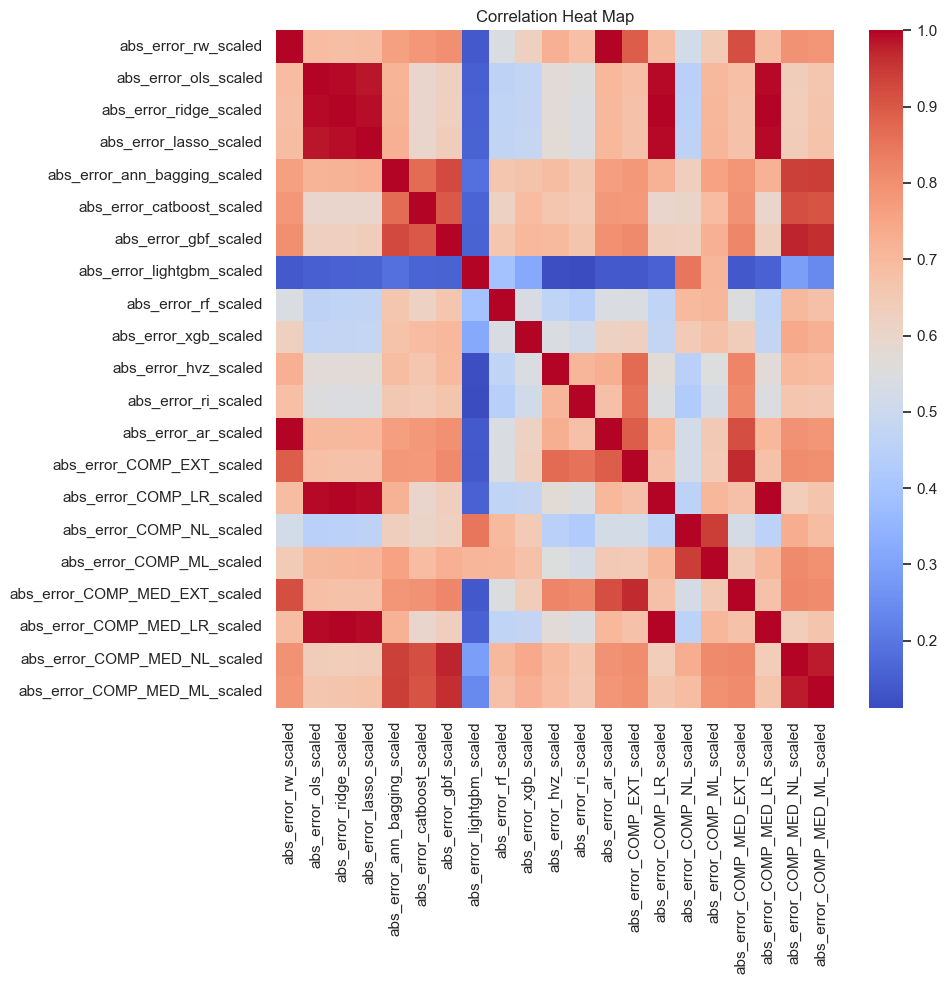

In [42]:
# Calculate the correlation heat map for abs_error for all the models, including composite models
corr = df[["abs_error_rw_scaled", "abs_error_ols_scaled", "abs_error_ridge_scaled", "abs_error_lasso_scaled",
           "abs_error_ann_bagging_scaled", "abs_error_catboost_scaled", "abs_error_gbf_scaled",
           "abs_error_lightgbm_scaled", "abs_error_rf_scaled", "abs_error_xgb_scaled", "abs_error_hvz_scaled",
           "abs_error_ri_scaled", "abs_error_ar_scaled", "abs_error_COMP_EXT_scaled", "abs_error_COMP_LR_scaled",
           "abs_error_COMP_NL_scaled", "abs_error_COMP_ML_scaled", "abs_error_COMP_MED_EXT_scaled",
           "abs_error_COMP_MED_LR_scaled", "abs_error_COMP_MED_NL_scaled", "abs_error_COMP_MED_ML_scaled"]].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heat Map")
plt.tight_layout()
plt.show()

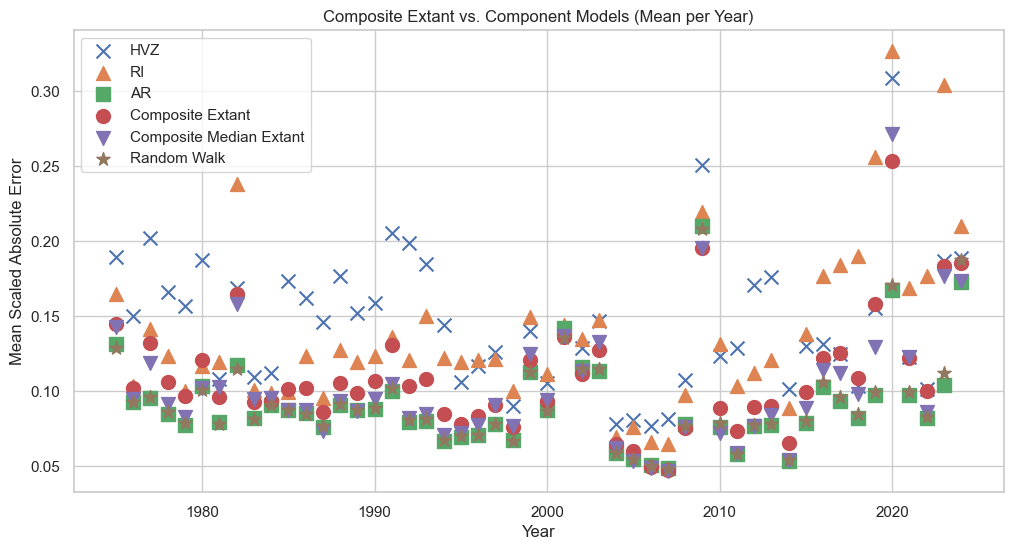

In [94]:
grouped = df.groupby("year").mean().reset_index()
grouped["year"] = grouped["year"].astype(int)

plt.figure(figsize=(12,6))
plt.scatter(grouped['year'], grouped["abs_error_hvz_scaled"], label="HVZ", marker='x', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ri_scaled"], label="RI", marker='^', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ar_scaled"], label="AR", marker='s', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_EXT_scaled"], label="Composite Extant", marker='o', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_MED_EXT_scaled"], label="Composite Median Extant", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Mean Scaled Absolute Error")
plt.title("Composite Extant vs. Component Models (Mean per Year)")
plt.legend()
plt.show()

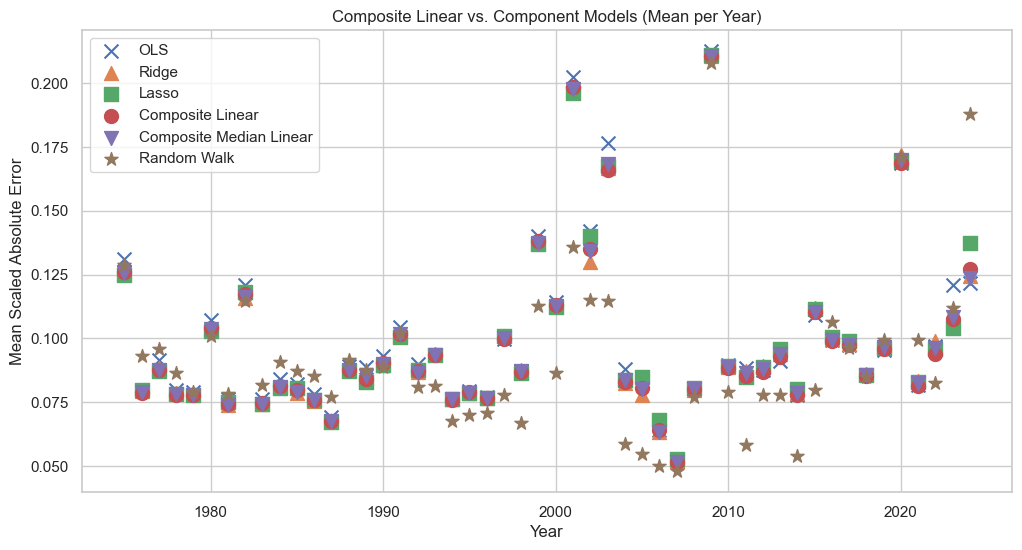

In [95]:
plt.figure(figsize=(12,6))
plt.scatter(grouped['year'], grouped["abs_error_ols_scaled"], label="OLS", marker='x', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ridge_scaled"], label="Ridge", marker='^', s=100)
plt.scatter(grouped['year'], grouped["abs_error_lasso_scaled"], label="Lasso", marker='s', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_LR_scaled"], label="Composite Linear", marker='o', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_MED_LR_scaled"], label="Composite Median Linear", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Mean Scaled Absolute Error")
plt.title("Composite Linear vs. Component Models (Mean per Year)")
plt.legend()
plt.show()

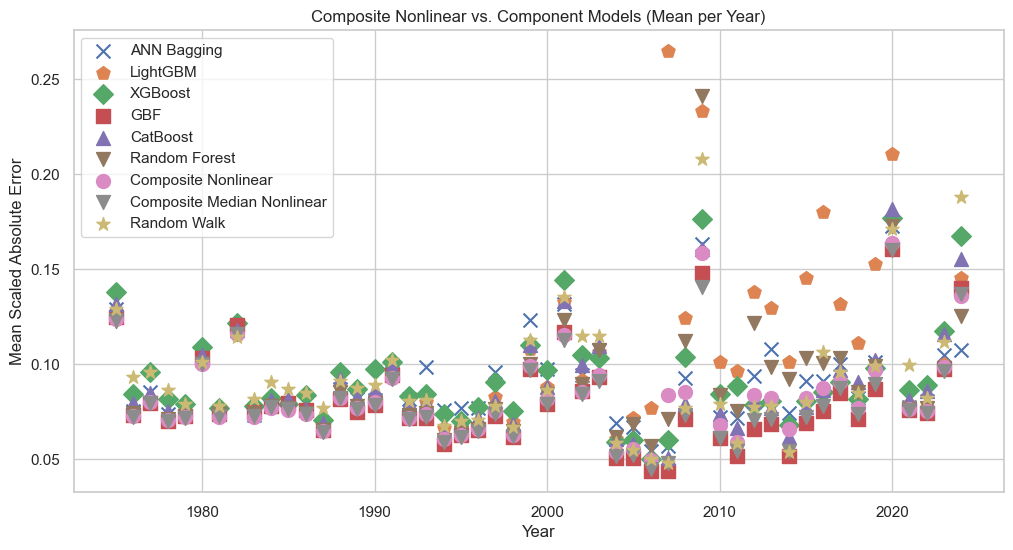

In [96]:
plt.figure(figsize=(12,6))
plt.scatter(grouped['year'], grouped["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped['year'], grouped["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped['year'], grouped["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped['year'], grouped["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped['year'], grouped["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_NL_scaled"], label="Composite Nonlinear", marker='o', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_MED_NL_scaled"], label="Composite Median Nonlinear", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Mean Scaled Absolute Error")
plt.title("Composite Nonlinear vs. Component Models (Mean per Year)")
plt.legend()
plt.show()

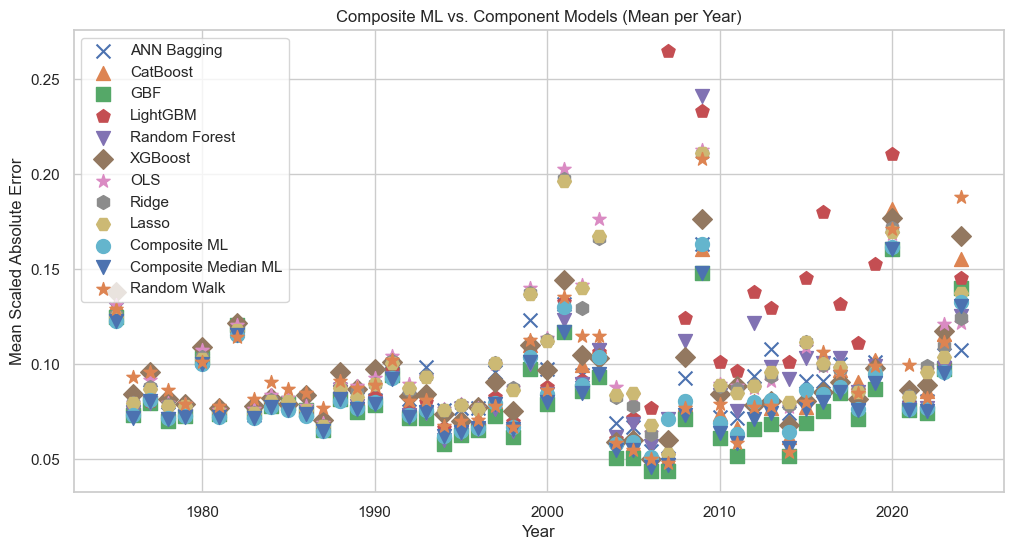

In [97]:
plt.figure(figsize=(12,6))
plt.scatter(grouped['year'], grouped["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped['year'], grouped["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped['year'], grouped["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped['year'], grouped["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ols_scaled"], label="OLS", marker='*', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ridge_scaled"], label="Ridge", marker='h', s=100)
plt.scatter(grouped['year'], grouped["abs_error_lasso_scaled"], label="Lasso", marker='H', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_ML_scaled"], label="Composite ML", marker='o', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_MED_ML_scaled"], label="Composite Median ML", marker='v', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Mean Scaled Absolute Error")
plt.title("Composite ML vs. Component Models (Mean per Year)")
plt.legend()
plt.show()

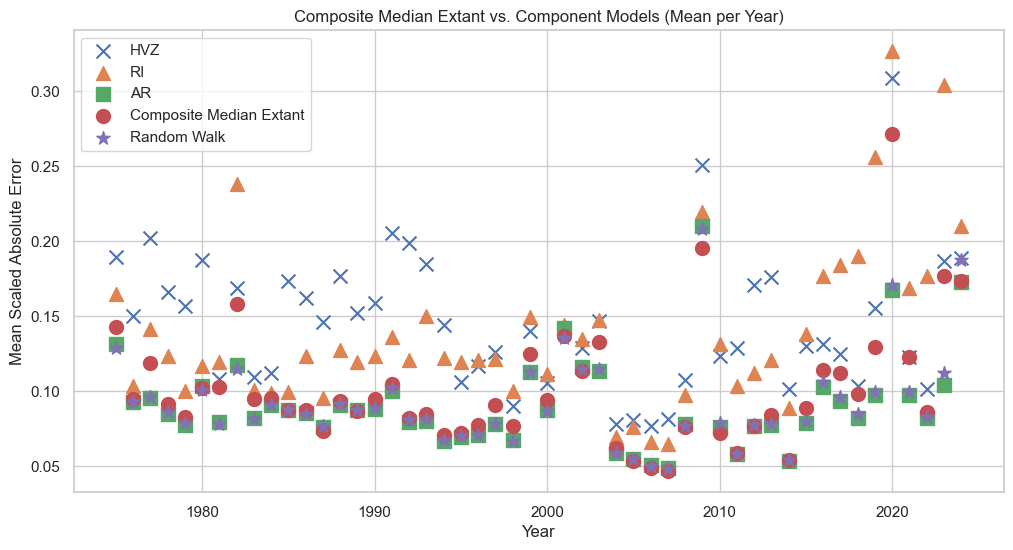

In [70]:
plt.figure(figsize=(12,6))
plt.scatter(grouped['year'], grouped["abs_error_hvz_scaled"], label="HVZ", marker='x', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ri_scaled"], label="RI", marker='^', s=100)
plt.scatter(grouped['year'], grouped["abs_error_ar_scaled"], label="AR", marker='s', s=100)
plt.scatter(grouped['year'], grouped["abs_error_COMP_MED_EXT_scaled"], label="Composite Median Extant", marker='o', s=100)
plt.scatter(grouped['year'], grouped["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Mean Scaled Absolute Error")
plt.title("Composite Median Extant vs. Component Models (Mean per Year)")
plt.legend()
plt.show()

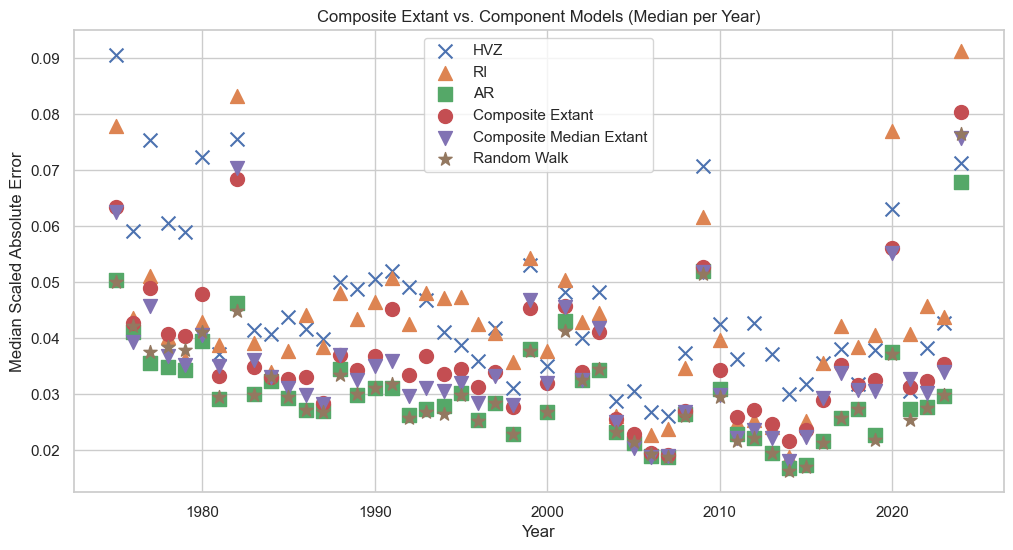

In [98]:
grouped_median = df.groupby("year").median().reset_index() 

plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_hvz_scaled"], label="HVZ", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ri_scaled"], label="RI", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ar_scaled"], label="AR", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_EXT_scaled"], label="Composite Extant", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_EXT_scaled"], label="Composite Median Extant", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Extant vs. Component Models (Median per Year)")
plt.legend()
plt.show()

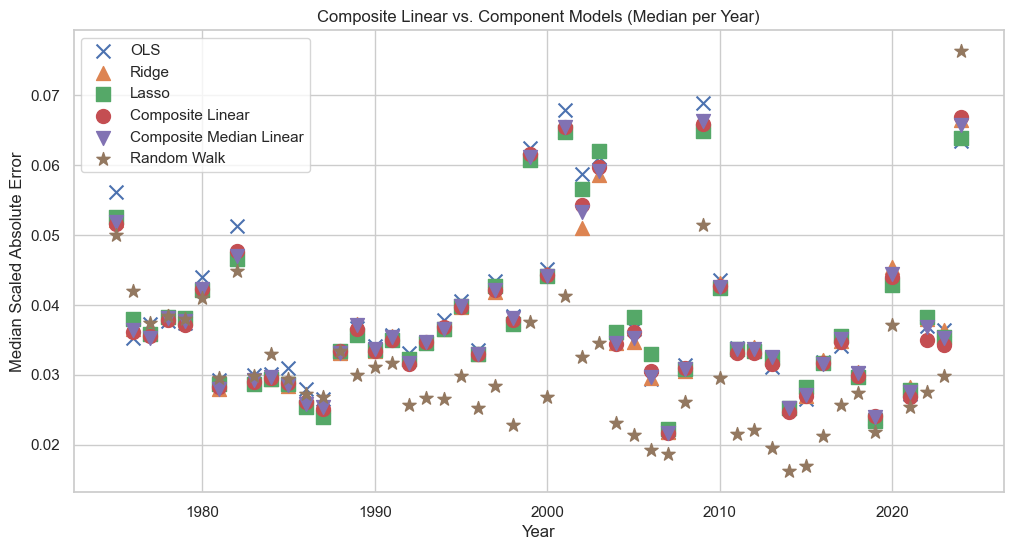

In [99]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ols_scaled"], label="OLS", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ridge_scaled"], label="Ridge", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lasso_scaled"], label="Lasso", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_LR_scaled"], label="Composite Linear", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_LR_scaled"], label="Composite Median Linear", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Linear vs. Component Models (Median per Year)")
plt.legend()
plt.show()

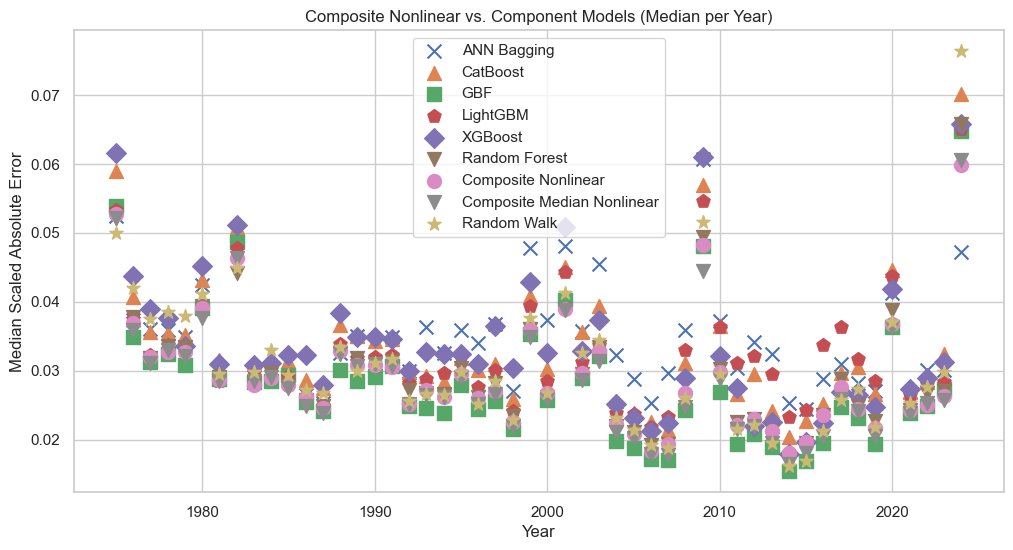

In [100]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_NL_scaled"], label="Composite Nonlinear", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_NL_scaled"], label="Composite Median Nonlinear", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Nonlinear vs. Component Models (Median per Year)")
plt.legend()
plt.show()

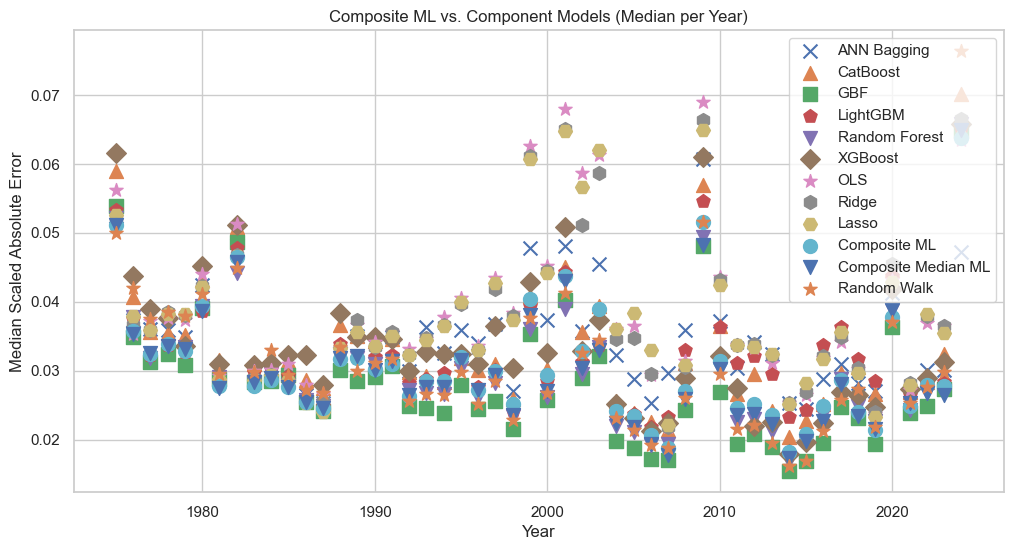

In [101]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ols_scaled"], label="OLS", marker='*', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ridge_scaled"], label="Ridge", marker='h', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lasso_scaled"], label="Lasso", marker='H', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_ML_scaled"], label="Composite ML", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_ML_scaled"], label="Composite Median ML", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite ML vs. Component Models (Median per Year)")
plt.legend()
plt.show()

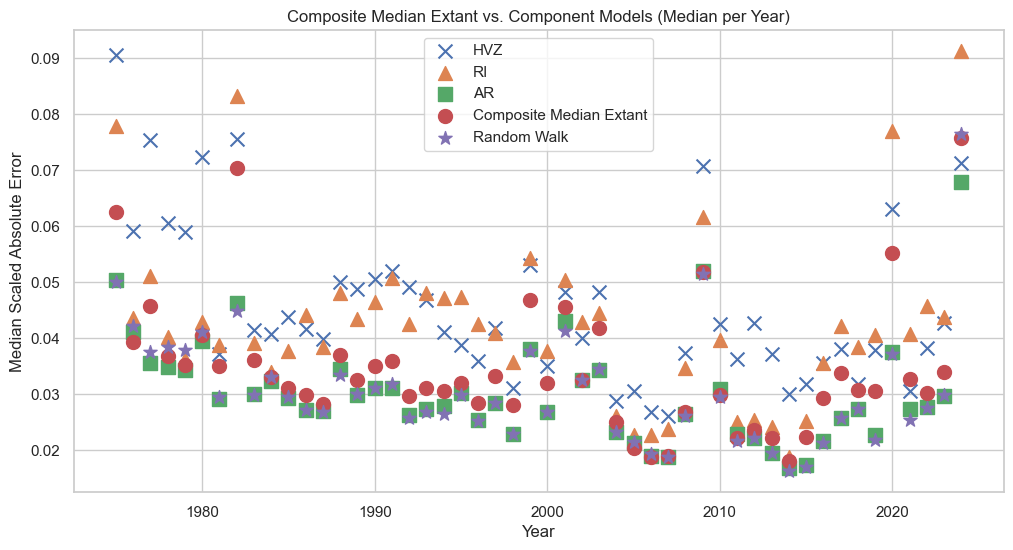

In [78]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_hvz_scaled"], label="HVZ", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ri_scaled"], label="RI", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ar_scaled"], label="AR", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_EXT_scaled"], label="Composite Median Extant", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Median Extant vs. Component Models (Median per Year)")
plt.legend()
plt.show()

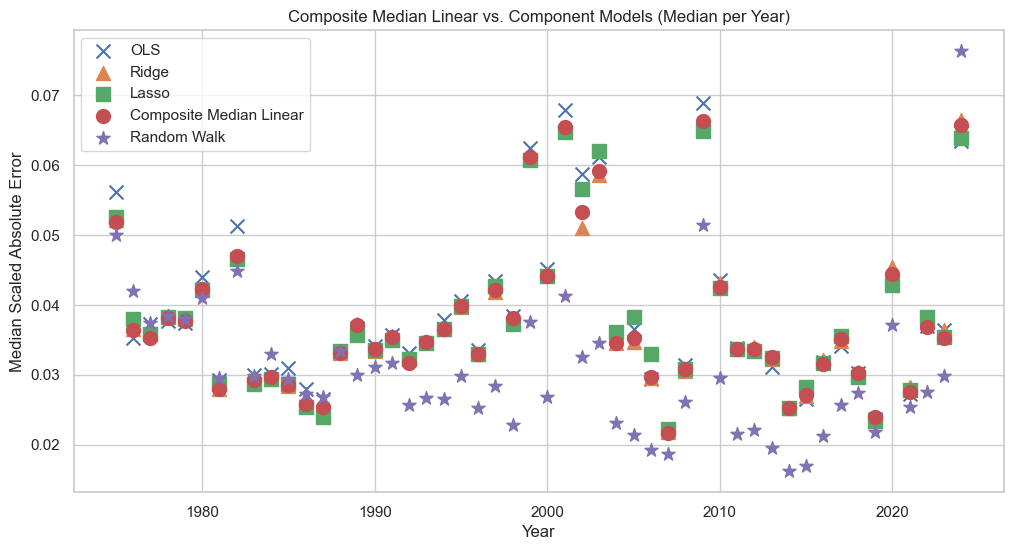

In [79]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ols_scaled"], label="OLS", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ridge_scaled"], label="Ridge", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lasso_scaled"], label="Lasso", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_LR_scaled"], label="Composite Median Linear", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Median Linear vs. Component Models (Median per Year)")
plt.legend()
plt.show()

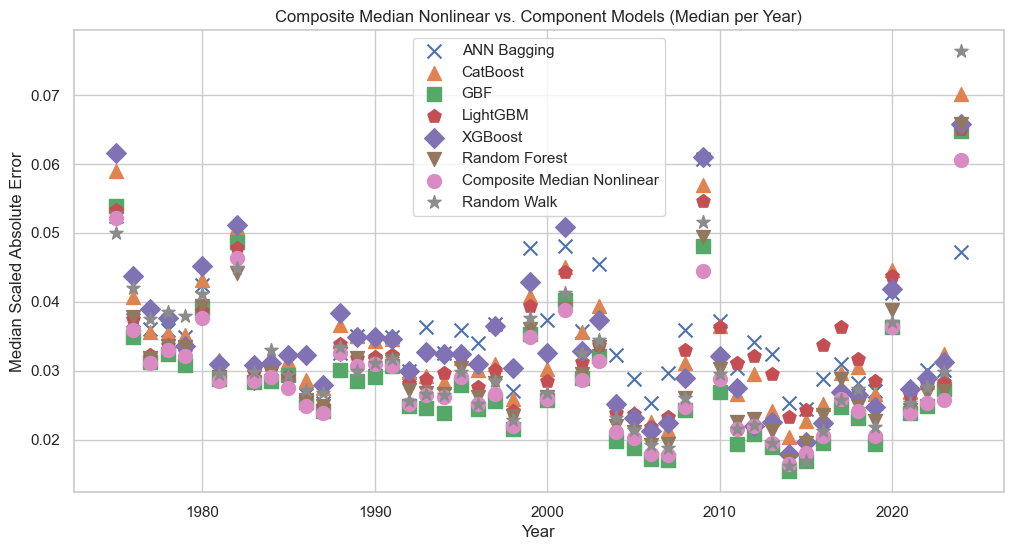

In [80]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_NL_scaled"], label="Composite Median Nonlinear", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Median Nonlinear vs. Component Models (Median per Year)")
plt.legend()
plt.show()

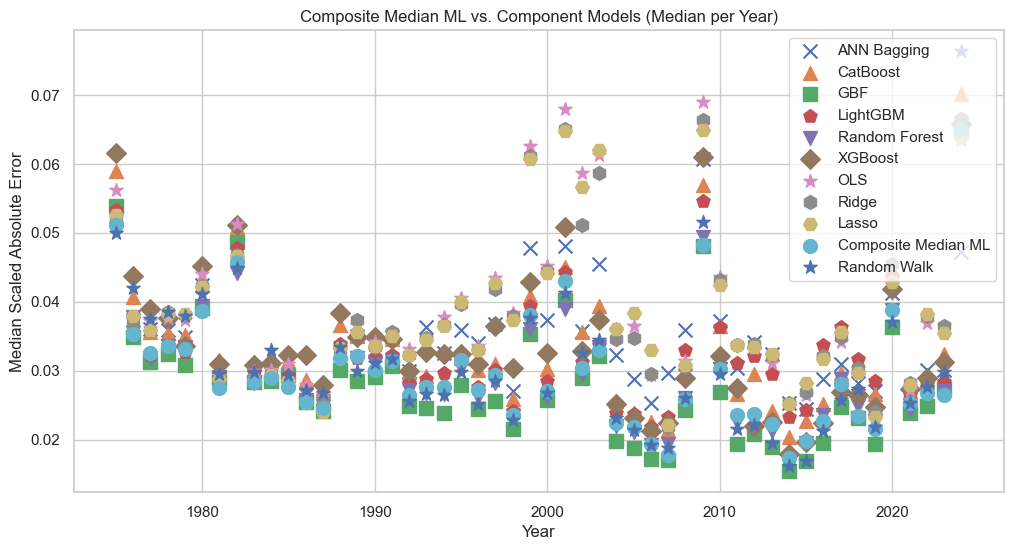

In [84]:
plt.figure(figsize=(12,6))
plt.scatter(grouped_median['year'], grouped_median["abs_error_ann_bagging_scaled"], label="ANN Bagging", marker='x', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_catboost_scaled"], label="CatBoost", marker='^', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_gbf_scaled"], label="GBF", marker='s', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lightgbm_scaled"], label="LightGBM", marker='p', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rf_scaled"], label="Random Forest", marker='v', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_xgb_scaled"], label="XGBoost", marker='D', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ols_scaled"], label="OLS", marker='*', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_ridge_scaled"], label="Ridge", marker='h', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_lasso_scaled"], label="Lasso", marker='H', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_COMP_MED_ML_scaled"], label="Composite Median ML", marker='o', s=100)
plt.scatter(grouped_median['year'], grouped_median["abs_error_rw_scaled"], label="Random Walk", marker='*', s=100)
plt.xlabel("Year")
plt.ylabel("Median Scaled Absolute Error")
plt.title("Composite Median ML vs. Component Models (Median per Year)")
plt.legend()
plt.show()

In [44]:
def newey_west_tstat(series, lags=3):
    """
    Computes the Newey-West t-statistic for a time series of differences.
    """
    if hasattr(series, 'values'):
        y = series.values
    else:
        y = series
    T = len(y)
    X = np.ones((T, 1))
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    tstat = model.tvalues[0]
    return tstat

In [45]:
composite_models = {
    "COMP_EXT": "abs_error_COMP_EXT_scaled",
    "COMP_LR": "abs_error_COMP_LR_scaled",
    "COMP_NL": "abs_error_COMP_NL_scaled",
    "COMP_ML": "abs_error_COMP_ML_scaled",
    "COMP_MED_EXT": "abs_error_COMP_MED_EXT_scaled",
    "COMP_MED_LR": "abs_error_COMP_MED_LR_scaled",
    "COMP_MED_NL": "abs_error_COMP_MED_NL_scaled",
    "COMP_MED_ML": "abs_error_COMP_MED_ML_scaled"
}
grouped = df.groupby("year")
results = {}

for model, col in composite_models.items():
    model_mean = grouped[col].mean()
    model_median = grouped[col].median()
    
    diff_mean = model_mean - benchmark_mean
    diff_median = model_median - benchmark_median

    DIFF_mean = diff_mean.mean()
    DIFF_median = diff_median.mean()
    
    pct_DIFF_mean = 100 * DIFF_mean / benchmark_mean.mean()
    pct_DIFF_median = 100 * DIFF_median / benchmark_median.mean()
    
    tstat_mean = newey_west_tstat(diff_mean, lags=3)
    tstat_median = newey_west_tstat(diff_median, lags=3)

    if isinstance(tstat_mean, tuple):
        tstat_mean = tstat_mean[0]
    if isinstance(tstat_median, tuple):
        tstat_median = tstat_median[0]
    
    results[model] = {
        "DIFF_mean": DIFF_mean,
        "tstat_mean": tstat_mean,
        "%DIFF_mean": pct_DIFF_mean,
        "DIFF_median": DIFF_median,
        "tstat_median": tstat_median,
        "%DIFF_median": pct_DIFF_median
    }

In [46]:
print("Composite Forecast Evaluation Relative to the Benchmark (Random Walk):\n")
for model, stats in results.items():
    print(f"{model}:")
    print(f"  Mean-based DIFF: {stats['DIFF_mean']:.4f}")
    print(f"  Newey-West t-statistic (mean): {stats['tstat_mean']:.4f}")
    print(f"  %DIFF (mean-based): {stats['%DIFF_mean']:.2f}%")
    print(f"  Median-based DIFF: {stats['DIFF_median']:.4f}")
    print(f"  Newey-West t-statistic (median): {stats['tstat_median']:.4f}")
    print(f"  %DIFF (median-based): {stats['%DIFF_median']:.2f}%\n")

Composite Forecast Evaluation Relative to the Benchmark (Random Walk):

COMP_EXT:
  Mean-based DIFF: 0.0197
  Newey-West t-statistic (mean): 2.8780
  %DIFF (mean-based): 22.11%
  Median-based DIFF: 0.0074
  Newey-West t-statistic (median): 3.6144
  %DIFF (median-based): 25.40%

COMP_LR:
  Mean-based DIFF: 0.0088
  Newey-West t-statistic (mean): 1.6850
  %DIFF (mean-based): 9.85%
  Median-based DIFF: 0.0085
  Newey-West t-statistic (median): 4.1443
  %DIFF (median-based): 29.34%

COMP_NL:
  Mean-based DIFF: -0.0056
  Newey-West t-statistic (mean): -1.6535
  %DIFF (mean-based): -6.28%
  Median-based DIFF: 0.0004
  Newey-West t-statistic (median): 0.2983
  %DIFF (median-based): 1.45%

COMP_ML:
  Mean-based DIFF: -0.0048
  Newey-West t-statistic (mean): -1.4459
  %DIFF (mean-based): -5.42%
  Median-based DIFF: 0.0017
  Newey-West t-statistic (median): 1.2079
  %DIFF (median-based): 5.80%

COMP_MED_EXT:
  Mean-based DIFF: 0.0121
  Newey-West t-statistic (mean): 1.7346
  %DIFF (mean-based): 

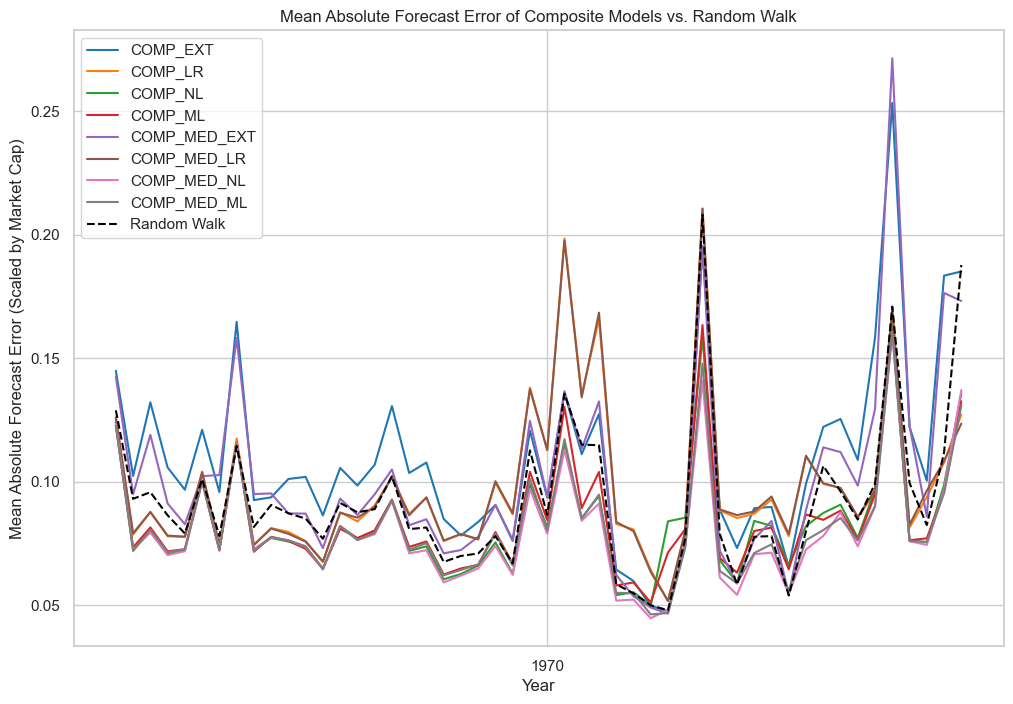

In [47]:
colors = plt.get_cmap("tab10").colors

fig, ax = plt.subplots(figsize=(12, 8))

for (model, col), color in zip(composite_models.items(), colors):
    yoy_error = grouped[col].mean()
    ax.plot(yoy_error.index, yoy_error, label=model, color=color)

yoy_error_rw = grouped["abs_error_rw_baseline"].mean()
ax.plot(yoy_error_rw.index, yoy_error_rw, label="Random Walk", linestyle="--", color="black")

ax.set_xlabel("Year")
ax.set_ylabel("Mean Absolute Forecast Error (Scaled by Market Cap)")
ax.set_title("Mean Absolute Forecast Error of Composite Models vs. Random Walk")
ax.legend()
plt.show()

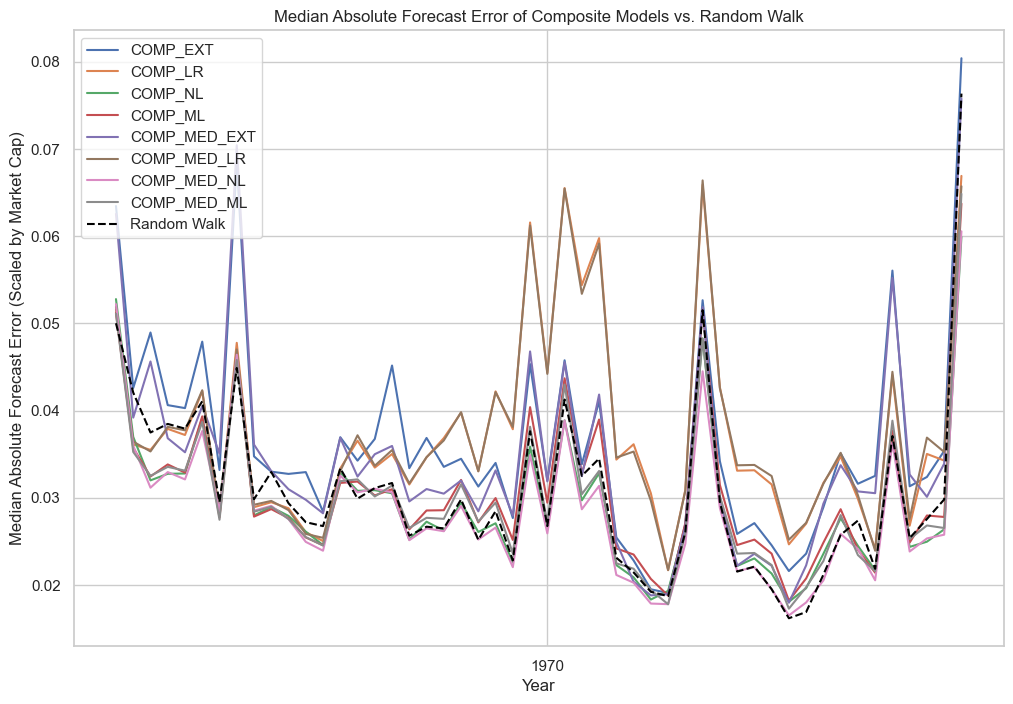

In [48]:
# Plot YoY median absolute forecast errors for each composite model vs. random walk (no confidence intervals)
fig, ax = plt.subplots(figsize=(12, 8))
for model, col in composite_models.items():
    yoy_error = grouped[col].median()
    ax.plot(yoy_error.index, yoy_error, label=model)
yoy_error_rw = grouped["abs_error_rw_baseline"].median()
ax.plot(yoy_error_rw.index, yoy_error_rw, label="Random Walk", linestyle="--", color="black")
ax.set_xlabel("Year")
ax.set_ylabel("Median Absolute Forecast Error (Scaled by Market Cap)")
ax.set_title("Median Absolute Forecast Error of Composite Models vs. Random Walk")
ax.legend()
plt.show()

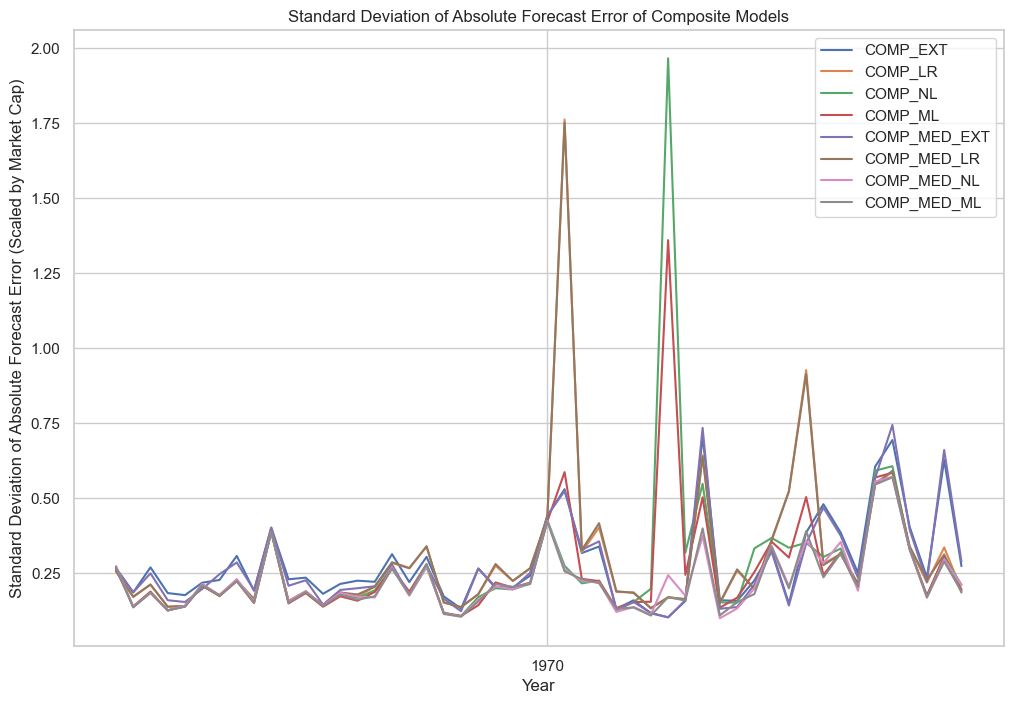

In [49]:
# Plot standard deviation of each composite model YoY absolute forecast errors
fig, ax = plt.subplots(figsize=(12, 8))
for model, col in composite_models.items():
    yoy_error = grouped[col].std()
    ax.plot(yoy_error.index, yoy_error, label=model)
ax.set_xlabel("Year")
ax.set_ylabel("Standard Deviation of Absolute Forecast Error (Scaled by Market Cap)")
ax.set_title("Standard Deviation of Absolute Forecast Error of Composite Models")
ax.legend()
plt.show()

In [50]:
# Describe the distribution of the standard deviation
grouped_std = df.groupby("year")[list(composite_models.values())].std()
display(grouped_std.describe())

,abs_error_COMP_EXT_scaled,abs_error_COMP_LR_scaled,abs_error_COMP_NL_scaled,abs_error_COMP_ML_scaled,abs_error_COMP_MED_EXT_scaled,abs_error_COMP_MED_LR_scaled,abs_error_COMP_MED_NL_scaled,abs_error_COMP_MED_ML_scaled
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.282083,0.301163,0.278345,0.266714,0.274247,0.301013,0.226127,0.222688
std,0.146516,0.260604,0.269682,0.200993,0.154263,0.258830,0.105415,0.105374
min,0.102103,0.131829,0.106279,0.106546,0.101748,0.132787,0.098828,0.104085
25%,0.183259,0.172416,0.167775,0.154661,0.166867,0.176137,0.156522,0.152893
50%,0.231448,0.215822,0.204655,0.204449,0.222811,0.218932,0.196846,0.186980
75%,0.324285,0.331079,0.314742,0.295713,0.325565,0.322905,0.271185,0.262062
max,0.705801,1.760992,1.965335,1.359104,0.743055,1.750892,0.570617,0.568609


In [51]:
# Drop the year 2024 from the dataset
df_final = df[df["year"] != 2024]
df_final.tail()

,gvkey,year,E,mkt_cap,E_future,E_pred_ols,E_pred_ann_bagging,E_pred_ar,E_pred_catboost,E_pred_gbf,...,abs_error_lasso_scaled,abs_error_ann_bagging_scaled,abs_error_catboost_scaled,abs_error_gbf_scaled,abs_error_lightgbm_scaled,abs_error_rf_scaled,abs_error_xgb_scaled,abs_error_hvz_scaled,abs_error_ri_scaled,abs_error_ar_scaled
137858,151423,1970-01-01 00:00:00.000002024,-1.575,23.091360,-5.773,-3.664694,-0.689453,-1.396778,-2.618559,-1.190806,...,0.247354,0.220149,0.136607,0.198438,0.147430,0.195969,0.240946,1.712032,2.243098,0.189518
137859,163118,1970-01-01 00:00:00.000002024,495.000,4675.499920,47.000,463.705304,442.118510,438.987466,689.548242,601.156266,...,0.103856,0.084508,0.137429,0.118523,0.088867,0.108674,0.071730,0.092240,0.095286,0.083839
137860,177405,1970-01-01 00:00:00.000002024,-56.175,46.977970,-79.641,-38.006570,-33.740799,-49.818426,-48.982850,-39.807732,...,0.957504,0.977058,0.652607,0.847914,0.717568,0.611885,1.089616,0.060543,0.506337,0.634820
137861,179690,1970-01-01 00:00:00.000002024,9.055,2103.388020,47.408,35.096524,58.574723,8.030367,103.071666,39.918492,...,0.029265,0.005309,0.026464,0.003561,0.016957,0.002802,0.008732,0.033267,0.022885,0.018721
137862,184442,1970-01-01 00:00:00.000002024,1050.980,7406.050656,79.390,1063.164294,585.713941,932.054640,1144.401599,858.872481,...,0.111464,0.068366,0.143803,0.105249,0.116738,0.123605,0.089802,0.153618,0.133924,0.115131


In [52]:
import polars as pl
df_final.to_csv("full_results/composite_forecasts.csv", index=False)
df_forecasts = pl.read_csv("full_results/composite_forecasts.csv")
df_forecasts.write_parquet("full_results/composite_forecasts.parquet")